In [1]:
# Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_iris
from pandas import Series, DataFrame

%matplotlib inline

### Movie info

In [2]:
# Read in the data as movie_info
# Use parse_dates and pass column name to read it as a datetime
movie_info = pd.read_csv('Data/rt.movie_info.tsv', encoding='latin-1', sep='\t', 
                        parse_dates=['theater_date', 'dvd_date'])
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13,2000-04-18,NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,1997-08-27,NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaT,NaT,NaN,NaN,200 minutes,NaN


In [3]:
movie_info.columns

Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')

In [4]:
# Info on the dataframe
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1560 non-null   int64         
 1   synopsis      1498 non-null   object        
 2   rating        1557 non-null   object        
 3   genre         1552 non-null   object        
 4   director      1361 non-null   object        
 5   writer        1111 non-null   object        
 6   theater_date  1201 non-null   datetime64[ns]
 7   dvd_date      1201 non-null   datetime64[ns]
 8   currency      340 non-null    object        
 9   box_office    340 non-null    object        
 10  runtime       1530 non-null   object        
 11  studio        494 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 146.4+ KB


### Cleaning the data

In [5]:
#checking how many null values there are in each column
movie_info.isnull().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

To clean my columns from the null values, I will be replacing the values in some of the columns with 'Missing" so that it's all consistent across the columns

In [6]:
#Fill the missing values in synposis, genre, director, writer, currency, studio with 'Missing'
movie_info['synopsis'].fillna('Missing', inplace=True)
movie_info['genre'].fillna('Missing', inplace=True)
movie_info['director'].fillna('Missing', inplace=True)
movie_info['writer'].fillna('Missing', inplace=True)
movie_info['currency'].fillna('Missing', inplace=True)
movie_info['studio'].fillna('Missing', inplace=True)


In [7]:
#Fill theater_date and dvd_date missing values with a generic date "1800-01-01" to keep same format
movie_info['theater_date'].fillna('1800-01-01', inplace=True)
movie_info['dvd_date'].fillna('1800-01-01', inplace=True)

In [8]:
#Fill box_office missing valus with 0
movie_info['box_office'].fillna(0, inplace=True)

### Step 1: let's look at the different variables within this data frame to see what factors contribute to successful movies


### We will first look at Runtime across movies, what's the most used runtime, what's the average?

In [9]:
movie_info['runtime'].value_counts()

90 minutes     72
95 minutes     66
100 minutes    51
93 minutes     47
96 minutes     43
               ..
240 minutes     1
5 minutes       1
178 minutes     1
229 minutes     1
54 minutes      1
Name: runtime, Length: 142, dtype: int64

In [10]:
movie_info['runtime']

0       104 minutes
1       108 minutes
2       116 minutes
3       128 minutes
4       200 minutes
           ...     
1555    106 minutes
1556     88 minutes
1557    111 minutes
1558    101 minutes
1559     94 minutes
Name: runtime, Length: 1560, dtype: object

We will change the type of runtime column into actual numbers so we can work on it

In [11]:
movie_info['runtime'] = movie_info['runtime'].str.replace('minutes',"")
movie_info['runtime'] = pd.to_numeric(movie_info['runtime'])

In [12]:
#to confirm that the type has changed
movie_info['runtime'].dtype

dtype('float64')

In [13]:
lowest_five_runtime = movie_info.sort_values('runtime', ascending=True)
lowest_five_runtime.head(5)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
1358,1753,Carmel Myers' co-star in this amusing farce is...,NR,Comedy,Paul Powell,Missing,1800-01-01,1800-01-01,Missing,0,5.0,Missing
540,707,James Pierce is one of the lesser-known film T...,NR,Action and Adventure,Missing,Missing,1800-01-01,1800-01-01,Missing,0,6.0,Missing
273,361,Missing,NR,Drama|Special Interest,Roberto Sanchez Santos,Missing,1800-01-01,1800-01-01,Missing,0,7.0,Missing
950,1229,A short fashion film.,NR,Documentary,Missing,Missing,1800-01-01,1800-01-01,Missing,0,10.0,Missing
983,1275,"Desperately seeking to save his marriage, Bren...",NR,Drama,Jen McGowan,Colin Pink|Jen McGowan,1800-01-01,1800-01-01,Missing,0,11.0,Missing


In [14]:
highest_five_runtime = movie_info.sort_values('runtime', ascending=False)
highest_five_runtime.head(5)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
639,823,Directed by Marco Tullio Giordana and La Megli...,R,Art House and International|Drama|Romance,Marco Tullio Giordana,Stefano Rulli|Sandro Petraglia,2003-06-22 00:00:00,2006-02-07 00:00:00,Missing,0,358.0,Miramax Films
508,666,"After twenty-five years, a trio of old high sc...",NR,Drama|Mystery and Suspense,Paul Wendkos,Missing,1800-01-01,1800-01-01,Missing,0,313.0,Missing
1111,1434,When a pay cut sends Australian dock workers o...,NR,Drama|Romance,Chris Thomson,Missing,1800-01-01,1800-01-01,Missing,0,294.0,Missing
1490,1918,A collection of 15 chapters from Tarzan and th...,NR,Action and Adventure|Classics|Documentary,Henry MacRae|Harry McRae,William Lord Wright|Ian McCloskey Heath,1929-10-01 00:00:00,2006-10-24 00:00:00,Missing,0,290.0,Missing
1029,1332,Based on the classic Nathaniel Hawthorne novel...,NR,Drama|Television,Rick Hauser,Missing,1800-01-01,1800-01-01,Missing,0,240.0,Missing


In [15]:
print(movie_info['runtime'].min())
print(movie_info['runtime'].max())

5.0
358.0


In [16]:
movie_info['runtime'].describe()

count    1530.000000
mean      103.967974
std        24.642392
min         5.000000
25%        91.000000
50%       100.000000
75%       114.000000
max       358.000000
Name: runtime, dtype: float64

In [17]:
movie_info['runtime'].mode

<bound method Series.mode of 0       104.0
1       108.0
2       116.0
3       128.0
4       200.0
        ...  
1555    106.0
1556     88.0
1557    111.0
1558    101.0
1559     94.0
Name: runtime, Length: 1560, dtype: float64>

Mean Value for Runtime column: 103.96797385620916
Median Value for Runtime column: 100.0


C:\Users\dtaher\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


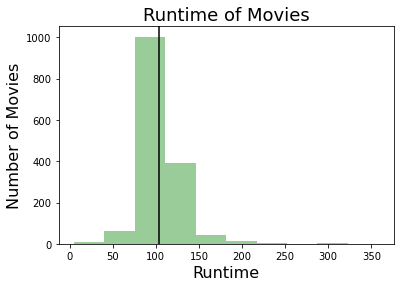

In [18]:
runtime_mean = movie_info['runtime'].mean()
runtime_median = movie_info['runtime'].median()

sns.distplot(movie_info['runtime'],kde=False, color='green', bins=10)
plt.axvline(x = movie_info['runtime'].mean(), color = 'black')
plt.title('Runtime of Movies', fontsize=18)
plt.xlabel('Runtime', fontsize=16)
plt.ylabel('Number of Movies', fontsize=16);

# # fig, ax = plt.subplots()

# sns.histplot(data=movie_info, x=['runtime']
# # plt.axvline(x = movie_info['runtime'].mean(), color = 'black')
# # ax.set_title("Runtime of Movies")
# # ax.set_xlabel("Runtime")
# # ax.set_ylabel("Number of Movies")

print("Mean Value for Runtime column: {}".format(runtime_mean))
print("Median Value for Runtime column: {}".format(runtime_median))

In [19]:
#previous method i used before seaborn
# runtime_mean = movie_info['runtime'].mean()
# runtime_median = movie_info['runtime'].median()

# fig, ax = plt.subplots()

# ax.hist(movie_info['runtime'])
# plt.axvline(x = movie_info['runtime'].mean(), color = 'black')
# ax.set_title("Runtime of Movies")
# ax.set_xlabel("Runtime")
# ax.set_ylabel("Number of Movies")

# print("Mean Value for Runtime column: {}".format(runtime_mean))
# print("Median Value for Runtime column: {}".format(runtime_median))

From the visualization above, we can see the data has a slightly positive skew.

**Dropping rows that contain missing values:** runtime column contains 30 null values in this case we will simply drop any rows that contain them. The number dropped does not constitute a significant portion of our dataset, so dropping the values is an acceptable loss

In [20]:
movie_info = movie_info.dropna(subset=['runtime'])
movie_info.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
currency        0
box_office      0
runtime         0
studio          0
dtype: int64

### let's check the rating and see what's the most popular rating

In [21]:
movie_info['rating'].value_counts()

R        519
NR       482
PG       239
PG-13    232
G         57
NC17       1
Name: rating, dtype: int64

In [22]:
movie_info['rating'].dtype

dtype('O')

In [23]:
# There are only 3 null values so let's drop them from the rating column 
movie_info = movie_info.dropna(subset=['rating'])
movie_info.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
currency        0
box_office      0
runtime         0
studio          0
dtype: int64

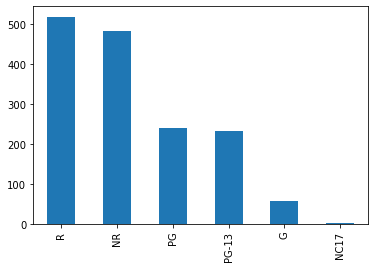

In [24]:
# now let's visualize it
movie_info['rating'].value_counts().plot(kind='bar');


C:\Users\dtaher\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


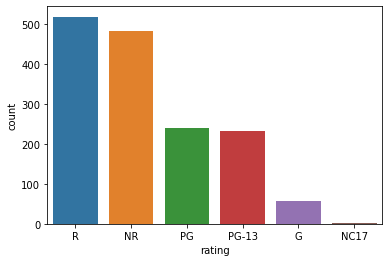

In [25]:
#I want to try seaborn visualization
sns.countplot(movie_info['rating']);

The graph shows us that the majority of movies are rated R

### Now let's examine the director column and see what we can extract from there
Is there a certain Director that is more successful than others that potentially could be hired to direct the movies?

In [26]:
movie_info['director'].value_counts()

Missing             185
Steven Spielberg     10
Clint Eastwood        8
Woody Allen           4
Alfred Hitchcock      4
                   ... 
Ulu Grosbard          1
Peyton Reed           1
Nicolas Roeg          1
Tim Burstall          1
Phil Roman            1
Name: director, Length: 1116, dtype: int64

In [27]:
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104.0,Missing
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17 00:00:00,2013-01-01 00:00:00,$,"600,000",108.0,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13 00:00:00,2000-04-18 00:00:00,Missing,0,116.0,Missing
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09 00:00:00,1997-08-27 00:00:00,Missing,0,128.0,Missing
4,7,Missing,NR,Drama|Romance,Rodney Bennett,Giles Cooper,1800-01-01,1800-01-01,Missing,0,200.0,Missing


In [28]:
director_count = movie_info['director'].value_counts()
director_count

Missing             185
Steven Spielberg     10
Clint Eastwood        8
Woody Allen           4
Alfred Hitchcock      4
                   ... 
Ulu Grosbard          1
Peyton Reed           1
Nicolas Roeg          1
Tim Burstall          1
Phil Roman            1
Name: director, Length: 1116, dtype: int64

In [29]:
director_count.nlargest(26)

Missing                185
Steven Spielberg        10
Clint Eastwood           8
Woody Allen              4
Alfred Hitchcock         4
William Beaudine         4
Jim Jarmusch             4
William Friedkin         4
Curtis Hanson            4
Barry Levinson           4
Ridley Scott             4
Yimou Zhang              4
Bruce Beresford          4
Martha Coolidge          3
Lawrence Kasdan          3
Joseph Ruben             3
Howard Hawks             3
Phil Alden Robinson      3
Mike Figgis              3
Peter Bogdanovich        3
George Cukor             3
Sylvester Stallone       3
Anatole Litvak           3
David Lean               3
Charles Walters          3
George Sidney            3
Name: director, dtype: int64

In [30]:
director_count.sort_values(ascending=False)[:25]

Missing               185
Steven Spielberg       10
Clint Eastwood          8
William Friedkin        4
Yimou Zhang             4
Ridley Scott            4
Barry Levinson          4
Curtis Hanson           4
Bruce Beresford         4
Jim Jarmusch            4
Alfred Hitchcock        4
Woody Allen             4
William Beaudine        4
Richard Linklater       3
Fritz Lang              3
Gerald Thomas           3
John Landis             3
Hong Sang-soo           3
Boris Sagal             3
David Fincher           3
Ang Lee                 3
John Frankenheimer      3
Hark Tsui               3
David Swift             3
George Sidney           3
Name: director, dtype: int64

In [31]:
top_director = movie_info['director'].value_counts().sort_values(ascending=False).head(25)
top_director

Missing               185
Steven Spielberg       10
Clint Eastwood          8
William Friedkin        4
Yimou Zhang             4
Ridley Scott            4
Barry Levinson          4
Curtis Hanson           4
Bruce Beresford         4
Jim Jarmusch            4
Alfred Hitchcock        4
Woody Allen             4
William Beaudine        4
Richard Linklater       3
Fritz Lang              3
Gerald Thomas           3
John Landis             3
Hong Sang-soo           3
Boris Sagal             3
David Fincher           3
Ang Lee                 3
John Frankenheimer      3
Hark Tsui               3
David Swift             3
George Sidney           3
Name: director, dtype: int64

In [32]:
top_director = top_director.drop(labels="Missing")

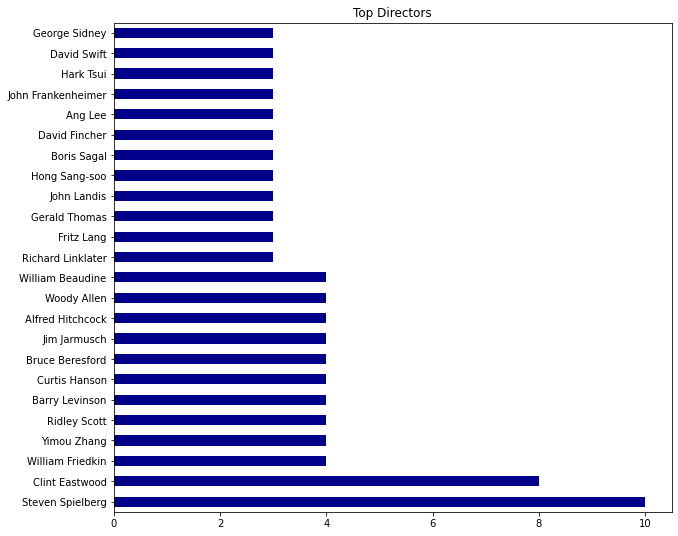

In [33]:
top_director.plot.barh(stacked=False, title= 'Top Directors', color=('DarkBlue'), figsize=(10,9));

In [34]:
top_director.value_counts()

3     12
4     10
10     1
8      1
Name: director, dtype: int64

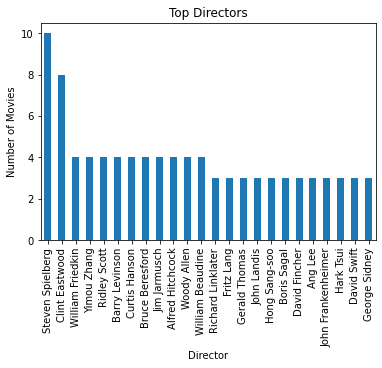

In [35]:
ax = top_director.plot.bar()
ax.set_title('Top Directors')
ax.set_xlabel('Director')
ax.set_ylabel('Number of Movies');              

### Relating everything together
Now that we've looked at different variables such as runtime, rating, top directors.
I will look at these variables in relation with profit and check whether any of them have a direct relationship with the amount of profit.

For this, I will be using Morgan's work on the budget table since I need the profit, and go from there.

I will get some of Morgan's work on the budget table

### Movies Budget table

In [36]:
budgets = pd.read_csv("data/tn.movie_budgets.csv")
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In this table we will assume that Revenue = 'worldwide_gross' & Cost = 'production_budget'

In [37]:
#will follow Morgan's data cleaning for this table
# removing $ and , from gross revenue
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(",","")
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace("$","")

# casting the values as integers
budgets['worldwide_gross'] = pd.to_numeric(budgets['worldwide_gross'])

In [38]:
# removing $ and , from production budget
budgets['production_budget'] = budgets['production_budget'].str.replace(",","")
budgets['production_budget'] = budgets['production_budget'].str.replace("$","")

# casting the values as integers
budgets['production_budget'] = pd.to_numeric(budgets['production_budget'])

In [39]:
# calculating total profit = revenue - cost
budgets['total_profit'] =  budgets['worldwide_gross'] - budgets['production_budget']

# confirmation
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875",1045663875,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,"$42,762,350",149762350,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,"$459,005,868",1403013963,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,"$620,181,382",1316721747,999721747


From here on I will continue my work of comparing the total profit from the budgets table to the different factors in the movie_info table

### Merging budget and Movie_info databases

I want to look at the different trends in relation to the total profit and first see if there are any relevant relationship. If there is, it will help get to a conclusion. I first need to merge the 2 tables together.

In [40]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1530 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1530 non-null   int64  
 1   synopsis      1530 non-null   object 
 2   rating        1530 non-null   object 
 3   genre         1530 non-null   object 
 4   director      1530 non-null   object 
 5   writer        1530 non-null   object 
 6   theater_date  1530 non-null   object 
 7   dvd_date      1530 non-null   object 
 8   currency      1530 non-null   object 
 9   box_office    1530 non-null   object 
 10  runtime       1530 non-null   float64
 11  studio        1530 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 195.4+ KB


In [41]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   int64 
 6   total_profit       5782 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 316.3+ KB


I will join the dataframes using an **inner** join because it returns only the records with matching keys in both tables, I will make a separate dataframe for the joined dataframes.

In [42]:
movie_info_budget = budgets.join(movie_info, how='inner', lsuffix = '_budgets' , rsuffix = '_movie_info')
movie_info_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1530 entries, 0 to 1559
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_budgets         1530 non-null   int64  
 1   release_date       1530 non-null   object 
 2   movie              1530 non-null   object 
 3   production_budget  1530 non-null   int64  
 4   domestic_gross     1530 non-null   object 
 5   worldwide_gross    1530 non-null   int64  
 6   total_profit       1530 non-null   int64  
 7   id_movie_info      1530 non-null   int64  
 8   synopsis           1530 non-null   object 
 9   rating             1530 non-null   object 
 10  genre              1530 non-null   object 
 11  director           1530 non-null   object 
 12  writer             1530 non-null   object 
 13  theater_date       1530 non-null   object 
 14  dvd_date           1530 non-null   object 
 15  currency           1530 non-null   object 
 16  box_office         1530 

In [43]:
movie_info_budget.head()

,id_budgets,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit,id_movie_info,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279,2351345279,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104.0,Missing
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875",1045663875,635063875,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17 00:00:00,2013-01-01 00:00:00,$,"600,000",108.0,Entertainment One
2,3,"Jun 7, 2019",Dark Phoenix,350000000,"$42,762,350",149762350,-200237650,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13 00:00:00,2000-04-18 00:00:00,Missing,0,116.0,Missing
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,"$459,005,868",1403013963,1072413963,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09 00:00:00,1997-08-27 00:00:00,Missing,0,128.0,Missing
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,"$620,181,382",1316721747,999721747,7,Missing,NR,Drama|Romance,Rodney Bennett,Giles Cooper,1800-01-01,1800-01-01,Missing,0,200.0,Missing


In [44]:
#I want to check how many have 0 for worldwide gross to drop these value
movie_info_budget.sort_values(['worldwide_gross'],ascending=True)

,id_budgets,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit,id_movie_info,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
1208,9,"Sep 20, 2019",Ad Astra,49800000,$0,0,-49800000,1554,The movie chronicles the adventures of a young...,G,Kids and Family|Musical and Performing Arts,Britt Allcroft,Britt Allcroft,2000-07-26 00:00:00,2000-10-31 00:00:00,$,"2,027,042",95.0,Destination Films
1206,7,"Nov 8, 2019",Arctic Dogs,50000000,$0,0,-50000000,1550,Missing,NR,Action and Adventure|Drama,Ralph Habib|Lee Robinson,Missing,1800-01-01,1800-01-01,Missing,0,93.0,Missing
1207,8,"Nov 22, 2019",The Rhythm Section,50000000,$0,0,-50000000,1553,Captain Virat Bakshi (Akshay Kumar) is a soldi...,NR,Action and Adventure|Drama|Mystery and Suspens...,Missing,Missing,1800-01-01,1800-01-01,$,"707,672",161.0,Reliance Entertainment
951,52,"Dec 11, 2015",The Ridiculous 6,60000000,$0,0,-60000000,1231,"THE ROVER, David Michod's highly anticipated f...",R,Mystery and Suspense|Science Fiction and Fanta...,Missing,Missing,2014-06-13 00:00:00,2014-09-23 00:00:00,$,"709,133",103.0,A24 Films
952,53,"Nov 8, 2019",Midway,59500000,$0,0,-59500000,1232,Few figures in professional baseball had a car...,NR,Drama|Television,Peter Bogdanovich,Christian Darren,2004-09-25 00:00:00,2005-03-29 00:00:00,Missing,0,120.0,Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,34,"Jun 12, 2015",Jurassic World,215000000,"$652,270,625",1648854864,1433854864,45,Hawaiian surfer dudes Stew (Steve Van Wormer) ...,PG,Comedy|Kids and Family,Steve Boyum,Jim Herzfeld|Dale Pollock,1800-01-01,1800-01-01,Missing,0,92.0,Missing
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,"$678,815,482",2048134200,1748134200,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,2002-01-11 00:00:00,2002-06-18 00:00:00,$,"41,032,915",82.0,Paramount Pictures
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,"$936,662,225",2053311220,1747311220,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,2000-03-03 00:00:00,2000-07-11 00:00:00,Missing,0,95.0,Warner Bros. Pictures
42,43,"Dec 19, 1997",Titanic,200000000,"$659,363,944",2208208395,2008208395,55,A progressive scientist builds a machine that ...,NR,Action and Adventure|Science Fiction and Fantasy,Henning Schellerup,Missing,1800-01-01,1800-01-01,Missing,0,99.0,Missing


In [45]:
movie_info_budget['worldwide_gross'].describe()

count    1.530000e+03
mean     2.373694e+08
std      2.688401e+08
min      0.000000e+00
25%      6.756215e+07
50%      1.521442e+08
75%      3.039617e+08
max      2.776345e+09
Name: worldwide_gross, dtype: float64

In [46]:
#dropped 0 from worldwide in new data frame
movie_info_budget1 = movie_info_budget.loc[movie_info_budget['worldwide_gross'] > 0 ] 


In [47]:
movie_info_budget1['worldwide_gross'].describe()

count    1.516000e+03
mean     2.395615e+08
std      2.691048e+08
min      2.225400e+04
25%      6.974157e+07
50%      1.536530e+08
75%      3.070034e+08
max      2.776345e+09
Name: worldwide_gross, dtype: float64

I will look to see if there are trends between the count of movies per director vs. the total profit 

In [48]:
#Create top directors df so that we can visualize top directors and top profit
director_counts = pd.DataFrame(movie_info_budget1.groupby('director')['movie'].count())
director_counts

,movie
director,
Abel Ferrara,2
Adam Ravetch|Sarah Robertson,1
Adam Shankman,1
Adam Silver|Ben Hayflick,1
Aditya Chopra,1
...,...
Youssef Delara,1
Yves Simoneau,1
Zak Penn,1


In [49]:
director_total_profit = pd.DataFrame(movie_info_budget1.groupby('director')['total_profit'].sum())
director_total_profit

,total_profit
director,
Abel Ferrara,236643115
Adam Ravetch|Sarah Robertson,72525156
Adam Shankman,225500000
Adam Silver|Ben Hayflick,122981799
Aditya Chopra,546865
...,...
Youssef Delara,-11019637
Yves Simoneau,109558505
Zak Penn,168700000


In [50]:
top_directors = director_counts.join(director_total_profit, how='outer', lsuffix = '_director_counts' , rsuffix = 'director_total_profit')
top_directors


,movie,total_profit
director,,
Abel Ferrara,2,236643115
Adam Ravetch|Sarah Robertson,1,72525156
Adam Shankman,1,225500000
Adam Silver|Ben Hayflick,1,122981799
Aditya Chopra,1,546865
...,...,...
Youssef Delara,1,-11019637
Yves Simoneau,1,109558505
Zak Penn,1,168700000


In [51]:
top_directors = top_directors.sort_values(by='total_profit', ascending=False)
top_directors

,movie,total_profit
director,,
Missing,181,32061478984
William Friedkin,4,2705957834
Henning Schellerup,1,2008208395
Steven Spielberg,10,1777836004
Jake Kasdan,1,1748134200
...,...,...
Oley Sassone,1,-75978328
Robert Hartford-Davis,1,-94635231
Renny Harlin,2,-111069937


In [52]:
top_directors = top_directors.drop(labels="Missing")

In [53]:
top_directors.corr()

,movie,total_profit
movie,1.00000,0.42006
total_profit,0.42006,1.00000


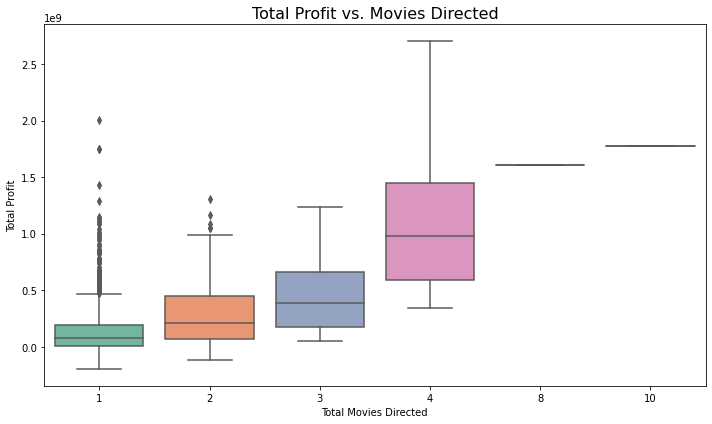

In [54]:
# Plot total profit vs. count of movies directed 
plt.figure(figsize=(10,6))
sns.boxplot(x = top_directors['movie'], y =top_directors['total_profit'], palette=("Set2"))
plt.title('Total Profit vs. Movies Directed', fontsize=16)
plt.xlabel('Total Movies Directed')
plt.ylabel('Total Profit')
plt.tight_layout()
plt.show()

From this plot it looks like directors with experience directing 3 or more movies resulted in almost always positive total profit. Now I want to look at directors with the highest average total profit.

In [55]:
top_directors['avg_profit'] =  top_directors['total_profit']/top_directors['movie']
top_directors['avg_profit'].head()

director
William Friedkin      6.764895e+08
Henning Schellerup    2.008208e+09
Steven Spielberg      1.777836e+08
Jake Kasdan           1.748134e+09
Jay Russell           1.747311e+09
Name: avg_profit, dtype: float64

In [56]:
top_directors['avg_profit'] = top_directors['avg_profit'].sort_values(ascending=False)

In [57]:
top_directors

,movie,total_profit,avg_profit
director,,,
William Friedkin,4,2705957834,6.764895e+08
Henning Schellerup,1,2008208395,2.008208e+09
Steven Spielberg,10,1777836004,1.777836e+08
Jake Kasdan,1,1748134200,1.748134e+09
Jay Russell,1,1747311220,1.747311e+09
...,...,...,...
Oley Sassone,1,-75978328,-7.597833e+07
Robert Hartford-Davis,1,-94635231,-9.463523e+07
Renny Harlin,2,-111069937,-5.553497e+07


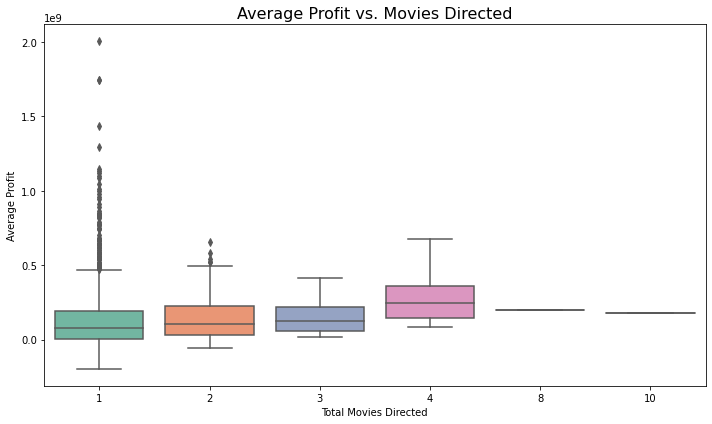

In [58]:
# Plot total profit vs. count of movies directed 
plt.figure(figsize=(10,6))
sns.boxplot(x = top_directors['movie'], y = top_directors['avg_profit'], palette=("Set2"))
plt.title('Average Profit vs. Movies Directed', fontsize=16)
plt.xlabel('Total Movies Directed')
plt.ylabel('Average Profit')
plt.tight_layout()
plt.show()

Did the boxplot again by average profit so it's a more accurate representation with the aberage rather than the total

Because there are outliers in Directors that only directed 1 movie, I will check the average profit for only the directors that directed 3 or more movies and then sort them by highest average profit to get the best directors in terms of average profit

In [59]:
#Getting the top 20 directors that directed 3 or more movies
three_plus_movies = top_directors[(top_directors['movie'] >= 3)].head(25)
three_plus_movies

,movie,total_profit,avg_profit
director,,,
William Friedkin,4,2705957834,6.764895e+08
Steven Spielberg,10,1777836004,1.777836e+08
Clint Eastwood,8,1607570579,2.009463e+08
Woody Allen,4,1546517681,3.866294e+08
Yimou Zhang,4,1458132256,3.645331e+08
Barry Levinson,4,1435779099,3.589448e+08
Boris Sagal,3,1237332495,4.124442e+08
Jim Jarmusch,4,1050825592,2.627064e+08
Werner Herzog,3,911024954,3.036750e+08


In [60]:
three_plus_movies

,movie,total_profit,avg_profit
director,,,
William Friedkin,4,2705957834,6.764895e+08
Steven Spielberg,10,1777836004,1.777836e+08
Clint Eastwood,8,1607570579,2.009463e+08
Woody Allen,4,1546517681,3.866294e+08
Yimou Zhang,4,1458132256,3.645331e+08
Barry Levinson,4,1435779099,3.589448e+08
Boris Sagal,3,1237332495,4.124442e+08
Jim Jarmusch,4,1050825592,2.627064e+08
Werner Herzog,3,911024954,3.036750e+08


In [61]:
three_plus_movies = three_plus_movies.reset_index()
three_plus_movies

,director,movie,total_profit,avg_profit
0,William Friedkin,4,2705957834,6.764895e+08
1,Steven Spielberg,10,1777836004,1.777836e+08
2,Clint Eastwood,8,1607570579,2.009463e+08
3,Woody Allen,4,1546517681,3.866294e+08
4,Yimou Zhang,4,1458132256,3.645331e+08
5,Barry Levinson,4,1435779099,3.589448e+08
6,Boris Sagal,3,1237332495,4.124442e+08
7,Jim Jarmusch,4,1050825592,2.627064e+08
8,Werner Herzog,3,911024954,3.036750e+08
9,Howard Hawks,3,909512843,3.031709e+08


In [62]:
three_plus_movies.columns

Index(['director', 'movie', 'total_profit', 'avg_profit'], dtype='object')

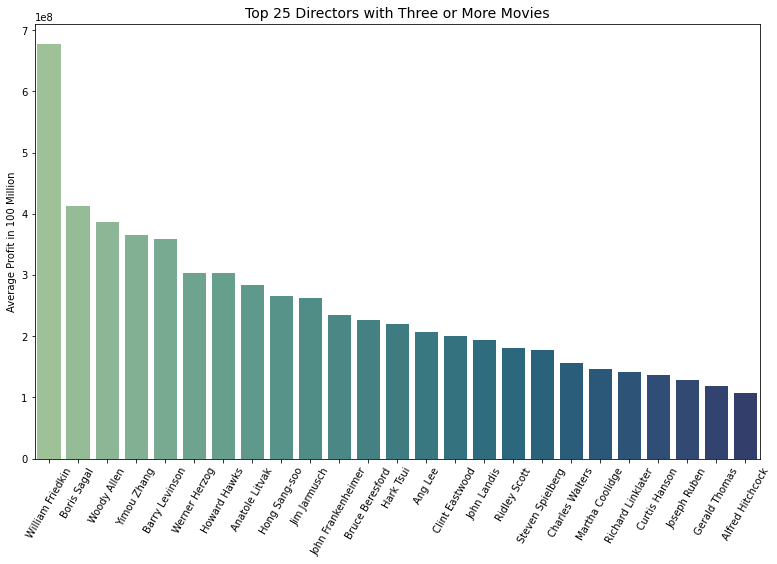

In [63]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.barplot(x = three_plus_movies['director'], y = three_plus_movies['avg_profit'], order= three_plus_movies.sort_values('avg_profit',ascending = False).director, palette="crest")
plt.xticks(rotation=60)
plt.xlabel(None)
plt.ylabel('Average Profit in 100 Million')
plt.title('Top 25 Directors with Three or More Movies', fontsize=14)
plt.show();

The directors portrayed have all delivered profitable movies. Therefore it is recommended to hire one of the top 10 director.

### Rating vs. Total profit

In [64]:
#Create rating df so that we can visualize runtime in relation to total profit
rating_count = pd.DataFrame(movie_info_budget1.groupby('rating')['movie'].count())
rating_count

,movie
rating,
G,56
NC17,1
NR,476
PG,238
PG-13,231
R,514


In [65]:
rating_total_profit = pd.DataFrame(movie_info_budget1.groupby('rating')['total_profit'].sum())
rating_total_profit

,total_profit
rating,
G,6516157583
NC17,160300000
NR,73262875690
PG,33330500655
PG-13,37565019683
R,85737978093


In [66]:
best_rating = rating_count.join(rating_total_profit, how='outer', lsuffix = '_rating_count' , rsuffix = '_rating_total_profit')
best_rating = best_rating.sort_values(by='total_profit', ascending=False)
best_rating

,movie,total_profit
rating,,
R,514,85737978093
NR,476,73262875690
PG-13,231,37565019683
PG,238,33330500655
G,56,6516157583
NC17,1,160300000


In [67]:
best_rating.corr()

,movie,total_profit
movie,1.000000,0.996583
total_profit,0.996583,1.000000


In [68]:
best_rating['avg_profit'] =  best_rating['total_profit']/best_rating['movie']
best_rating['avg_profit'].head()

rating
R        1.668054e+08
NR       1.539136e+08
PG-13    1.626191e+08
PG       1.400441e+08
G        1.163600e+08
Name: avg_profit, dtype: float64

In [69]:
best_rating['avg_profit'] = best_rating['avg_profit'].sort_values(ascending=False)
best_rating

,movie,total_profit,avg_profit
rating,,,
R,514,85737978093,1.668054e+08
NR,476,73262875690,1.539136e+08
PG-13,231,37565019683,1.626191e+08
PG,238,33330500655,1.400441e+08
G,56,6516157583,1.163600e+08
NC17,1,160300000,1.603000e+08


In [70]:
best_rating = best_rating.reset_index()
best_rating

,rating,movie,total_profit,avg_profit
0,R,514,85737978093,1.668054e+08
1,NR,476,73262875690,1.539136e+08
2,PG-13,231,37565019683,1.626191e+08
3,PG,238,33330500655,1.400441e+08
4,G,56,6516157583,1.163600e+08
5,NC17,1,160300000,1.603000e+08


C:\Users\dtaher\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


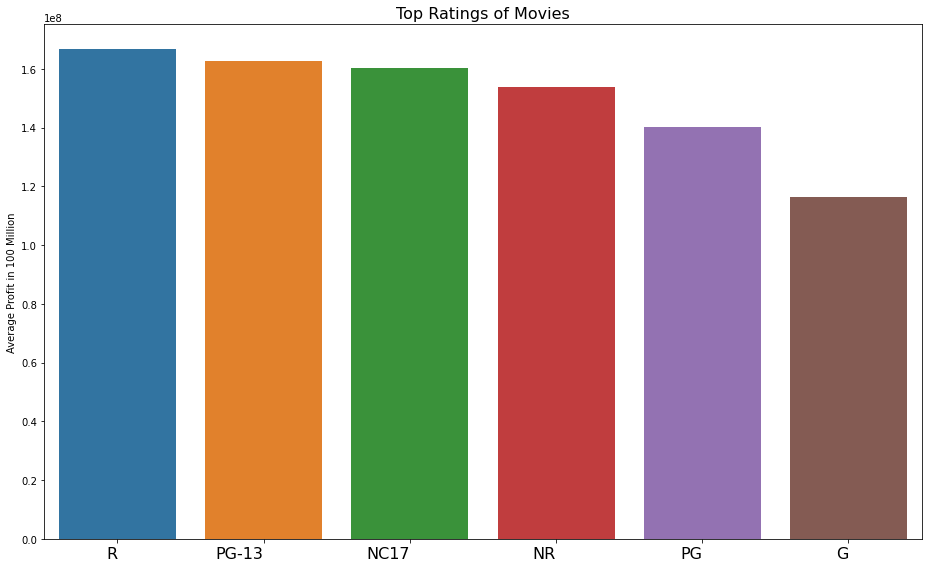

In [71]:
fig, ax = plt.subplots(figsize=(13, 8))
p = sns.barplot(best_rating['rating'],best_rating['avg_profit'], order= best_rating.sort_values('avg_profit',ascending = False).rating)
plt.xticks(horizontalalignment='right', fontsize=16)
plt.xlabel(None)
plt.ylabel('Average Profit in 100 Million')
plt.title('Top Ratings of Movies', fontsize=16)
plt.tight_layout()
plt.show();

### I dont think that's relevant to the recommendation
but oh well movies rated R have the highest profit on average

### back to the budgets data frame

In [72]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_profit
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875",1045663875,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,"$42,762,350",149762350,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,"$459,005,868",1403013963,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,"$620,181,382",1316721747,999721747


In [73]:
budgets.corr()

,id,production_budget,worldwide_gross,total_profit
id,1.000000,-0.035278,-0.009422,-0.001172
production_budget,-0.035278,1.000000,0.748306,0.608752
worldwide_gross,-0.009422,0.748306,1.000000,0.981811
total_profit,-0.001172,0.608752,0.981811,1.000000


I want to look at the budget in relation to the profit, maybe I can find what's a good budget to usually start with to make a profitable movie

In [74]:
budgets.value_counts('production_budget')

production_budget
20000000    231
10000000    212
30000000    177
15000000    173
25000000    171
           ... 
13900000      1
14200000      1
14400000      1
14600000      1
1100          1
Length: 509, dtype: int64

In [75]:
budget_per_movie = pd.DataFrame(budgets.groupby('production_budget')['movie'].count())
budget_per_movie

,movie
production_budget,
1100,1
1400,1
5000,1
6000,1
7000,5
...,...
317000000,1
330600000,1
350000000,1


In [76]:
budget_total_profit = pd.DataFrame(budgets.groupby('production_budget')['total_profit'].sum())
budget_total_profit

,total_profit
production_budget,
1100,179941
1400,-1400
5000,-3662
6000,234495
7000,2921398
...,...
317000000,999721747
330600000,1072413963
350000000,-200237650


In [77]:
highest_budget = budget_per_movie.join(budget_total_profit, how='outer', lsuffix = '_budget_per_movie' , rsuffix = '_budget_total_profit')
highest_budget = highest_budget.sort_values(by='total_profit', ascending=False)
highest_budget

,movie,total_profit
production_budget,,
200000000,22,14529331598
150000000,41,13485650061
40000000,170,9578708893
30000000,177,9059419156
20000000,231,8596782900
...,...,...
77500000,2,-51449409
59500000,1,-59500000
46500000,2,-69251120


In [78]:
highest_budget= highest_budget.reset_index()
highest_budget

,production_budget,movie,total_profit
0,200000000,22,14529331598
1,150000000,41,13485650061
2,40000000,170,9578708893
3,30000000,177,9059419156
4,20000000,231,8596782900
...,...,...,...
504,77500000,2,-51449409
505,59500000,1,-59500000
506,46500000,2,-69251120
507,67000000,2,-90526302


In [79]:
highest_budget=highest_budget.sort_values('production_budget',ascending=False)[:25]
highest_budget

,production_budget,movie,total_profit
43,425000000,1,2351345279
105,410600000,1,635063875
508,350000000,1,-200237650
73,330600000,1,1072413963
76,317000000,1,999721747
53,306000000,1,1747311220
29,300000000,4,3347120757
80,275000000,4,920370661
149,260000000,1,326477240
104,258000000,1,636860230


C:\Users\dtaher\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


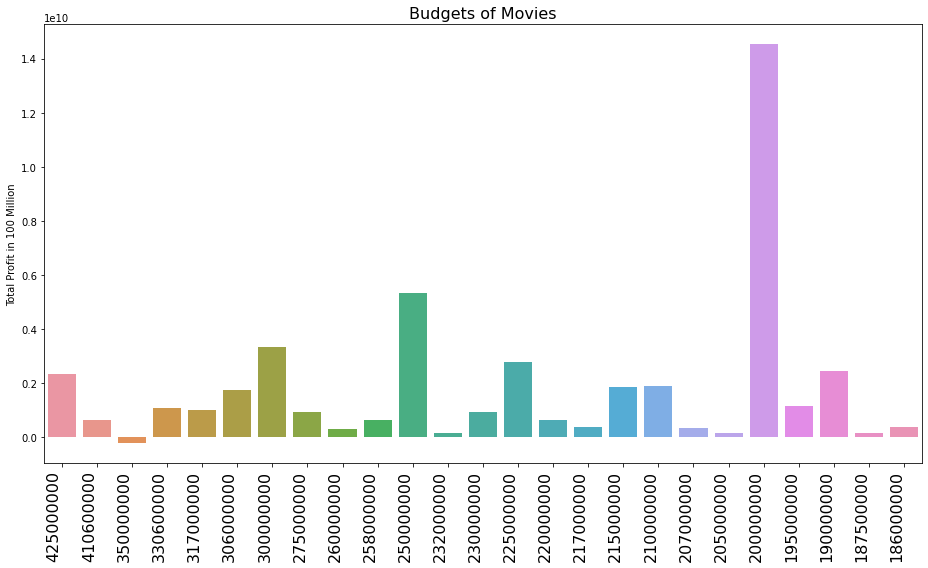

In [80]:
fig, ax = plt.subplots(figsize=(13, 8))
p = sns.barplot(highest_budget['production_budget'],highest_budget['total_profit'], order= highest_budget.sort_values('production_budget',ascending = False).production_budget)
plt.xticks(rotation=90, horizontalalignment='right', fontsize=16)
plt.xlabel(None)
plt.ylabel('Total Profit in 100 Million')
plt.title('Budgets of Movies', fontsize=16)
plt.tight_layout()
plt.show();

IDK how relevant this is but this is demonstrating that if we increase the budget, the total profit won't necessarily increase. The graph shows that the highest production budget doesn't have the highest profit. It looks like a budget of 20 Million is looking profitable.

### Looking at tmdb data set
### tmdb Movies

In [81]:
tmdb = pd.read_csv('Data/tmdb.movies.csv', index_col=0, parse_dates=['release_date'])
tmdb

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...
26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [82]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          26517 non-null  object        
 1   id                 26517 non-null  int64         
 2   original_language  26517 non-null  object        
 3   original_title     26517 non-null  object        
 4   popularity         26517 non-null  float64       
 5   release_date       26517 non-null  datetime64[ns]
 6   title              26517 non-null  object        
 7   vote_average       26517 non-null  float64       
 8   vote_count         26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 2.0+ MB


In [83]:
# it looks like we don't have any null values, but just to confirm:
tmdb.isna().sum()

genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [84]:
tmdb.describe()

,id,popularity,vote_average,vote_count
count,26517.000000,26517.000000,26517.000000,26517.000000
mean,295050.153260,3.130912,5.991281,194.224837
std,153661.615648,4.355229,1.852946,960.961095
min,27.000000,0.600000,0.000000,1.000000
25%,157851.000000,0.600000,5.000000,2.000000
50%,309581.000000,1.374000,6.000000,5.000000
75%,419542.000000,3.694000,7.000000,28.000000
max,608444.000000,80.773000,10.000000,22186.000000


### Look at Movies by popularity

Top Ten movies:

In [85]:
top_ten_movies_by_pop=tmdb.pivot_table(values='popularity',index="original_title").sort_values(ascending=False,by='popularity').head(10)
top_ten_movies_by_pop

,popularity
original_title,
Avengers: Infinity War,80.773
John Wick,78.123
Spider-Man: Into the Spider-Verse,60.534
The Hobbit: The Battle of the Five Armies,53.783
The Avengers,50.289
Guardians of the Galaxy,49.606
Blade Runner 2049,48.571
Fantastic Beasts: The Crimes of Grindelwald,48.508
Ralph Breaks the Internet,48.057


Bottom Ten movies

In [86]:
Bottom_ten_movies_by_pop=tmdb.pivot_table(values='popularity',index="original_title").sort_values(ascending=True,by='popularity').head(10)
Bottom_ten_movies_by_pop

,popularity
original_title,
"""BLESSED""",0.6
Lenny Cooke,0.6
Leolex,0.6
Leonard Cohen - Songs from the Road,0.6
Leonard in Slow Motion,0.6
Leones,0.6
Leopard,0.6
Les Profs,0.6
Lemonade + Ducktape Stuffs,0.6


### Looking into release date to see if there is a certain time of the year that has higher releases

To organize our data and make it simpler to visualize, I will go ahead and drop the columns that I won't be using for better visibility

In [87]:
# Drop the irrelevant columns
drop_columns = ['original_title','original_language','genre_ids']
tmdb.drop(drop_columns, axis=1, inplace=True)
tmdb.head()

,id,popularity,release_date,title,vote_average,vote_count
0,12444,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,10191,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,10138,28.515,2010-05-07,Iron Man 2,6.8,12368
3,862,28.005,1995-11-22,Toy Story,7.9,10174
4,27205,27.920,2010-07-16,Inception,8.3,22186


In [88]:
# getting only the year in release_date to make things simpler
# Coercion is the implicit conversion of an instance of one type to another
# during an operation which involves two arguments of the same type.
tmdb['year'] = pd.to_datetime(tmdb['release_date'], errors='coerce').apply(lambda x: str(x).split('-')
                                                                       [0] if x != np.nan else np.nan)
tmdb['month'] = pd.to_datetime(tmdb['release_date'], errors='coerce').apply(lambda x: str(x).split('-')
                                                                       [1] if x != np.nan else np.nan)
tmdb

,id,popularity,release_date,title,vote_average,vote_count,year,month
0,12444,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,2010,11
1,10191,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,2010,03
2,10138,28.515,2010-05-07,Iron Man 2,6.8,12368,2010,05
3,862,28.005,1995-11-22,Toy Story,7.9,10174,1995,11
4,27205,27.920,2010-07-16,Inception,8.3,22186,2010,07
...,...,...,...,...,...,...,...,...
26512,488143,0.600,2018-10-13,Laboratory Conditions,0.0,1,2018,10
26513,485975,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1,2018,05
26514,381231,0.600,2018-10-01,The Last One,0.0,1,2018,10
26515,366854,0.600,2018-06-22,Trailer Made,0.0,1,2018,06
